This notebook is for understanding the behavior of the variance plane for cell-based coadds.

## Load in imports and data

Last working weekly: w2024_34

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

# plotting image with cell inputs
import lsst.geom as afwGeom

# interpolation mask threshold
import lsst.geom as geom

In [2]:
# collection = 'u/mgorsuch/assemble_cell_coadd_patch_61_d0508' # updated patch 61 collection
collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813

In [3]:
patch = 50

In [4]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [5]:
stitch_coadd = coadd.stitch() # fails with empty cells

In [6]:
cell_list_filled = list(coadd.cells.keys())

In [7]:
cell_list = []
cells_filled = [False] * 484

index = 0
for i in range(22):
    for j in range(22):
        cell_list.append(Index2D(x=j,y=i))

        for cell in cell_list_filled:
            if (j==cell.x) and (i==cell.y):
                cells_filled[index]=True

        index += 1

In [8]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [9]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.zeros([22,22])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [10]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## Cell Variance Distribution

### Plot 2D histogram of variance 
Mask cells with infinite/nan values

In [11]:
mask_mean_var_list = ma.masked_invalid(np.empty([22,22]))
mask_median_var_list = ma.masked_invalid(np.empty([22,22]))

for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
    
    var_array = coadd.cells[cell].inner.variance.array

    x_index = cell.x
    y_index = cell.y

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        mask_mean_var_list[y_index][x_index] = var_array[0][0] # insert the invalid value of inf to be masked at bottom of the cell
        mask_median_var_list[y_index][x_index] = var_array[0][0]
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    median_var = np.median(var_array[np.isfinite(var_array)])

    mask_mean_var_list[y_index][x_index] = mean_var
    mask_median_var_list[y_index][x_index] = median_var

mask_mean_var_list = ma.masked_invalid(mask_mean_var_list)
mask_median_var_list = ma.masked_invalid(mask_mean_var_list)

mask_mean_var_list = ma.masked_where(inputs_list == 0.0, mask_mean_var_list)
mask_median_var_list = ma.masked_where(inputs_list == 0.0, mask_median_var_list)

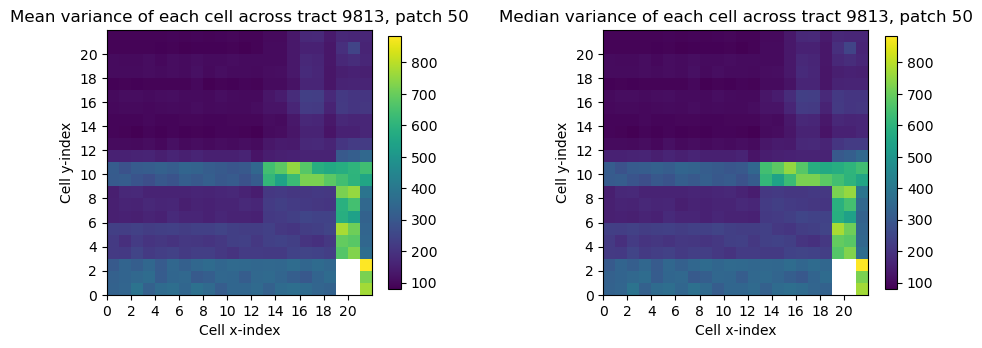

In [12]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

input_distrib = ax1.pcolormesh(mask_mean_var_list, 
                               shading='auto', 
                               vmin=mask_mean_var_list.min(), 
                               vmax=mask_mean_var_list.max())
ax1.set_title(f"Mean variance of each cell across tract 9813, patch {patch}")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.3)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
                             shading='auto', 
                             vmin=mask_median_var_list.min(), 
                             vmax=mask_median_var_list.max())
ax2.set_title(f"Median variance of each cell across tract 9813, patch {patch}")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.3)

plt.show()

### Compare cell input to cell variance

#### Compare the 2D histograms

First visually compare the two graphs

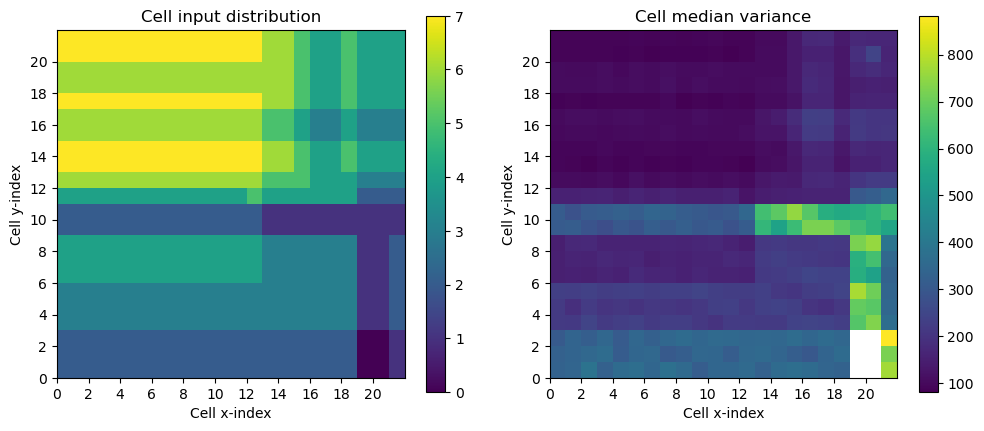

In [13]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
plt.tight_layout()

input_distrib = ax1.pcolormesh(inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max())
ax1.set_title("Cell input distribution")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.4)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
               shading='auto', 
               vmin=ma.min(mask_median_var_list[np.isfinite(mask_median_var_list)]), 
               vmax=ma.max(mask_median_var_list[np.isfinite(mask_median_var_list)]),)
ax2.set_title("Cell median variance")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

Compare directly the number of inputs to the effects in variance

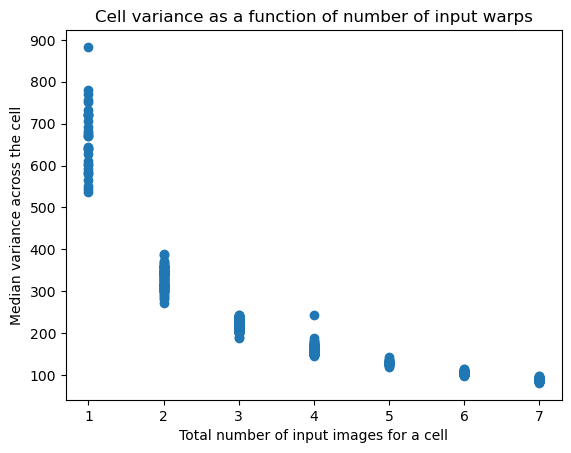

In [14]:
inputs_flat = inputs_list.flatten()
median_var_flat = mask_median_var_list.flatten()

plt.scatter(inputs_flat, median_var_flat)
plt.xlabel("Total number of input images for a cell")
plt.ylabel("Median variance across the cell")
plt.title("Cell variance as a function of number of input warps")
plt.show()

Can see now that more input images improve the variance, as expected.

### Verify weighted mean of the variance

Read in the weight of each cell using methods from `_compute_weight` in `assemble_cell_coadd`.

Iterate through the warps and their cells to determine several values for weighted means of the variance.
Only concerned with a single cell at a time for now.

In [15]:
accTask = AssembleCellCoaddTask()

weighted_var_list = []
var_coadd_list = []

var_test_cell = Index2D(x=21,y=21)

# check if cell is empty
cell_list_test = [not (var_test_cell==cell) for cell in cell_list_filled]
assert not np.all(cell_list_test), "Cell is empty"

for warp_visit in visits:
    
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = warp_visit)

    cell = coadd.cells[var_test_cell]
        
    # check if cell uses warp, skip cell if not
    cell_inputs = list(cell.inputs)
    cell_visits = [input.visit for input in cell_inputs]
    if not (np.isin(warp_visit, cell_visits)):
        continue
    
    x_index = var_test_cell.x
    y_index = var_test_cell.y

    bbox = cell.outer.bbox
    masked_im = warp[bbox].getMaskedImage()

    # compute weights from _compute_weight statistic
    computed_weight = accTask._compute_weight(masked_im, statsCtrl)
    
    # get the weighted var for this cell for a single pixel
    im_var_array_0 = masked_im.variance.array[0][0]
    weighted_var_list.append(computed_weight * im_var_array_0)
    # print(masked_im.mask.array[0][0] == 0) # check that the pixel doesn't have any masks (bit-value = 0)

    # get the weighted array of the variance
    weighted_var_array = computed_weight * masked_im.variance.array
    var_coadd_list.append(weighted_var_array)

    del warp

var_coadd_list = ma.masked_invalid(np.array(var_coadd_list))
var_coadd = np.nanmean(var_coadd_list, axis=0)

Compare the weighted sum from the input warps to the variance of that pixel to the cell.

0.88033557 141.3182 141.3182


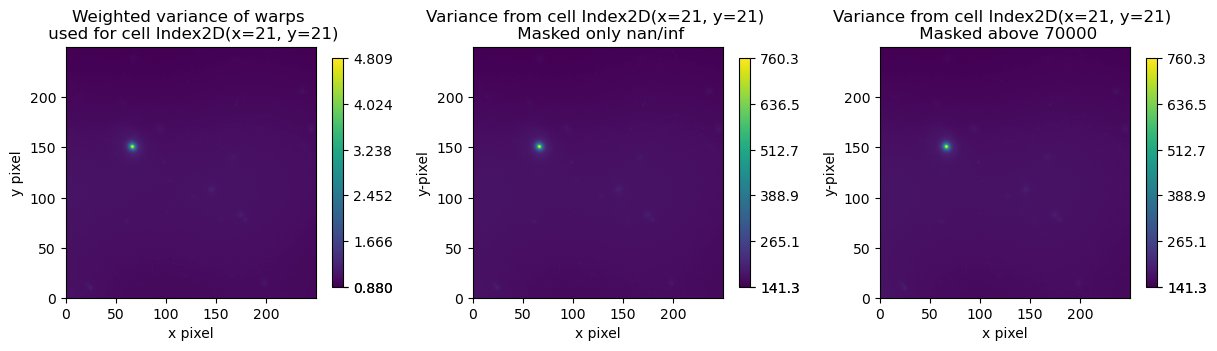

In [16]:
# get the variance from test cell
cell_0 = coadd.cells[var_test_cell]
var_0_all = ma.masked_invalid(np.array(cell_0.outer.variance.array))
var_0_small = ma.masked_greater_equal(var_0_all, 70000) # add additional mask to show range
print(var_coadd.min(), var_0_all.min(), var_0_small.min())

fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

warp_var_distrib = ax1.pcolormesh(var_coadd, 
                               shading='auto', 
                               vmin=var_coadd.min(), 
                               vmax=var_coadd.max(),)

ax1.set_title(f"Weighted variance of warps \n used for cell {var_test_cell}")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_coadd.min()
ticks1 = np.append(ticks1, np.linspace(var_coadd.min(), var_coadd.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_coadd.max())

fig.colorbar(warp_var_distrib, ax=ax1, cmap='viridis', shrink=0.2, ticks=ticks1)

cell_var_all = ax2.pcolormesh(var_0_all, 
                             shading='auto', 
                             vmin=var_0_all.min(), 
                             vmax=var_0_all.max(),)
ax2.set_title(f"Variance from cell {var_test_cell} \n Masked only nan/inf")
ax2.set_xlabel("x pixel")
ax2.set_ylabel("y-pixel")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 249, 50))
ax2.set_yticks(np.arange(0, 249, 50))
ticks2 = var_0_all.min()
ticks2 = np.append(ticks2, np.linspace(var_0_all.min(), var_0_all.max(), 5, endpoint=False))
ticks2 = np.append(ticks2, var_0_all.max())
fig.colorbar(cell_var_all, ax=ax2, cmap='viridis', shrink=0.2, ticks=ticks2)

cell_var_small = ax3.pcolormesh(var_0_small, 
                             shading='auto', 
                             vmin=var_0_small.min(),
                             vmax=var_0_small.max(),)
ax3.set_title(f"Variance from cell {var_test_cell} \n Masked above 70000")
ax3.set_xlabel("x pixel")
ax3.set_ylabel("y-pixel")
ax3.set_aspect('equal')
ax3.set_xticks(np.arange(0, 249, 50))
ax3.set_yticks(np.arange(0, 249, 50))
ticks3 = var_0_small.min()
ticks3 = np.append(ticks3, np.linspace(var_0_small.min(), var_0_small.max(), 5, endpoint=False))
ticks3 = np.append(ticks3, var_0_small.max())
fig.colorbar(cell_var_small, ax=ax3, cmap='viridis', shrink=0.2, ticks=ticks3)

plt.show()

In [17]:
neg_cell = coadd.cells[var_test_cell].outer.variance.array
neg_values = neg_cell[np.where(neg_cell < 0)]
print(len(neg_values)) # should be 0!

0


#### Mask bit masks in cell variance plane

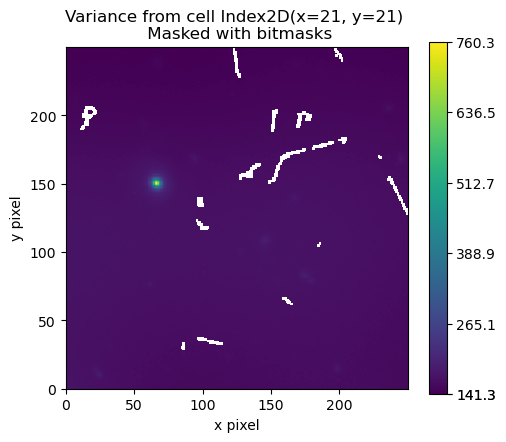

In [18]:
cell_0 = coadd.cells[var_test_cell]
cell_0_mask = cell_0.outer.mask

# create masks (elements where the mask occurs are set to True)
var_mask_intrp = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("INTRP")), True, False)
var_mask_sat = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("SAT")), True, False)
var_mask_streak = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("STREAK")), True, False)
var_mask_suspect = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("SUSPECT")), True, False)
var_mask_cr = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("CR")), True, False)
var_mask_nan = np.where(np.isfinite(cell_0.outer.variance.array), False, True)

# combine masks into a single mask. Any mask occuring will mask that element
all_mask = np.logical_or.reduce((var_mask_cr, var_mask_sat, var_mask_streak, var_mask_suspect, var_mask_cr, var_mask_nan))

# apply the mask to the variance plane of the cell
var_add_masks = ma.masked_array(cell_0.outer.variance.array, mask=all_mask)

fig,(ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

cell_add_masks = ax1.pcolormesh(var_add_masks, 
                               shading='auto', 
                               vmin=var_add_masks.min(), 
                               vmax=var_add_masks.max(),)

ax1.set_title(f"Variance from cell {var_test_cell} \n Masked with bitmasks")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_add_masks.min()
ticks1 = np.append(ticks1, np.linspace(var_add_masks.min(), var_add_masks.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_add_masks.max())

fig.colorbar(cell_add_masks, ax=ax1, cmap='viridis', shrink=0.8, ticks=ticks1)
plt.show()

In [19]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(cell_0.outer.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(cell_0.outer.image)

### Read in default coadds and look at variances

In [20]:
default_collection = 'u/mgorsuch/make_warp_61/20240508T162818Z'

In [21]:
default_coadd = butler.get('deepCoadd', 
                     collections=default_collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i',)

In [22]:
default_var = default_coadd.getVariance()
print(np.min(default_var.array))
print(np.max(default_var.array))
print(np.max(default_var.array[np.isfinite(default_var.array)]))

0.0009985425
inf
0.090337
